# Examples of Trading Strategies

This notebook utilizes the SIF infrastructure to implement a few basic trading strategies. The strategies are taken from [151 Trading Strategies](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3247865) (Kakushadze and Serur, 2018). The reader can refer to this paper for further details on the trading strategies.

The strategies implemented are:

* Momentum based on returns
* Momentum based on value 
* Single Moving average
* Double Moving average
* Triple Moving average
* Support and Resistance 


### Constructing the backtesting enviroment

Details on constructing the backtester using the SIF framework are presented in the [new_alpha_research](https://www.smithinvestmentfund.com/blog/alpha-research-workflow) notebook. Here we will emphasize how to implement different trading stratgies by creating a class for each strategy inhereted from `AbstractAlpha`. Within each class we have to write a function `generate_day` which should return an array of weights for the stocks that we need to hold everyday as specified by the strategy. Each function passes `data` which is a dictionary with `self.factor_list` as keys and a `(self.lookback + 1) x self.universe_size` array as values correspoinding to that factor. The last row of `data` represent the factor values for the current day.

For the purpose of this notebook, our backtest includes dates ranging from Jan 2010 to Jan 2020. We only consider  the top 500 stocks by market cap and we rebalance our portfolio every month. These options can be changed within the `FullMultipleBacktester` function.

As a first example, we create a class `Alpha` that consists of holding an equally weighted portfolio of all the stocks in our sepcified `universe`. This will be a useful index to compare our strategies against.

In [3]:
import datetime
import numpy as np
import pandas as pd

from sif_project.infrastructure.backtesters import full_backtesters as fb
from sif_project.infrastructure.alpha_eval import apply_metric_func
from sif_project.siftools import sif_utils as su, operators as op, metrics
from sif_project.siftools.abstractalpha import AbstractAlpha
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 9)

In [4]:
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

In [5]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
backtester = fb.FullMultipleBacktester(
    start_date,
    end_date,
    'M',
    273,
    500,
    ['open', 'close', 'high','low','pb']
)
backtester.save_local('alpha_research_data_2010.npy')
#backtester = fb.FullMultipleBacktester.from_local('alpha_research_data_2010.npy')
#sp_data = su.get_sp_close(start_date, end_date)  # Also pull S&P data for use later
#sp_ret = sp_data.pct_change()

0

In [14]:
class Alpha(AbstractAlpha):
    def __init__(self):
        self.name = 'Benchmark'
        self.lookback = 252
        self.factor_list = ['close']
        self.universe_size = 500
        
    def generate_day(self, day, data):
        """
        Portfolio holding equally weighted stocks
        """
        factor = np.full_like(data['close'][day], 1)

        return factor / sum(factor)


### Momentum based on returns

In a nutshell a momentum based strategy assumes that stocks that performed well in the past should continue to perform well in the future. There are different metrics for determining how stocks perform and for this strategy we will simply look at past returns. We will take a long position in the top 10% and short (sell) the bottom 10% in case of a long/short strategy.

Let $P_i(t)$ be the time series of closing prices for stock $i$, where $t$ is in months and $t=0$ is the most recent month. We can define a one month return, $R_i(t)$ by
\begin{equation}
R_i(t) = \frac{P_i(t)}{P_i(t+1)} - 1
\end{equation}

We can use different metrics to gauge which stocks have perfomed well by defining,
\begin{equation}
\begin{split}
&R_i^{cum} = \frac{P_i(S)}{P_i(S+T)} - 1 \\
&R_i^{mean} = \frac{1}{T} \sum_{t=S}^{S+T-1} R_i(t) \\
&\sigma^2_i = \frac{1}{T-1} \sum_{t=S}^{S+T-1} (R_i(t) - R_i^{mean})^2 \\
&R_i^{risk adj} = \frac{R_i^{mean}}{\sigma_i}
\end{split}
\end{equation}
where, $R_i^{cum}$ is the cumulative return over a $T$-month fomartion period (typically 12 months) and skipping the recent $S$-month (typically 1 month); $R_i^{mean}$ is the mean monthly return computed over the formation period; $\sigma_i$ is the monthly volatility; and $R_i^{risk adj}$ is the risk adjusted mean return over the formation period. In this example, we will pick the stocks based on mean monthly returns $R_i^{mean}$. 

The last thing to consider is whether to use a long-only or long-short strategy and how to weight each stock. We implement both strategies using uniform weights. For the long strategy the weights $w_i$ of the top 10% stocks are $w_i = \frac{1}{N}$, where $N$ is the number of stocks we are buying. Similarly for the long-short, we take $w_i = \frac{1}{2N_L}$ for the stocks we buy and $w_i = - \frac{1}{2N_S}$ for the stocks we sell, where $N_L$ and $N_S$ are the number of stocks we buy and sell respectively. 




In [15]:
class Momentum(AbstractAlpha):
    
    def __init__(self):
        self.name = 'Momentum'
        self.lookback = 273
        self.factor_list = ['close']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        '''
        Long only strategy. We skip the most recent month when looking at past returns. 
        '''
        skip =21
        
        # Computing the mean, standard deviation and risk adjusted returns
        returns = op.ret(data['close'][:-skip])
        mean_ret = op.mean(returns)
        std_ret = op.std(returns)
        riskadj_ret = mean_ret/std_ret
        
        # Sorting stocks according to returns
        ind = mean_ret.argsort()
        percentile = 0.1 # Picking the percentile of stocks to include in the portfolio
        limit= int(self.universe_size  * percentile)
        bottom_ind = ind[:limit] # Indices for stocks with lowest return
        top_ind = ind[-limit:] # Indices for stocks with highest return
        
        holdings = np.full_like(data['close'][day], 0)
        holdings[top_ind] = 1/len(top_ind) # Uniform weights for each stock
        
        return holdings

class Momentum_short(AbstractAlpha):
    def __init__(self):
        self.name = 'Momentum_short'
        self.lookback = 273
        self.factor_list = ['close']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        '''
        Long/Short strategy
        '''
        skip = 21
        
        returns = op.ret(data['close'][:-skip])
        mean_ret = op.mean(returns)
        std_ret = op.std(returns)
        riskadj_ret = mean_ret/std_ret
        
        ind = mean_ret.argsort()
        percentile = 0.1
        limit= int(self.universe_size  * percentile)
        bottom_ind = ind[:limit]
        top_ind = ind[-limit:]
        
        holdings = np.full_like(data['close'][day], 0)
        holdings[top_ind] = 1
        holdings[bottom_ind] = -1
        
        # op.weight calculates the weights so that the sum is 0 and sum of absolute values is 1
        return op.weight(holdings) 

### Momentum based on value

This strategy amounts to buying the winning stocks based on value. The defintion of value can vary from author to author; for our case we define value to be the Book-to-Market ratio. This ratio is simply the reciprocal of the variable `'pb'` (Price to Book or Market cap over Equity) in `self.factor_list`. 

In [16]:
class Value_Momentum(AbstractAlpha):
    
    def __init__(self):
        self.name = 'Value'
        self.lookback = 252
        self.factor_list = ['pb']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        
        # Value is defined to be Book to Market ratio
        BP = 1 / data['pb'][day]
        
        ind = BP.argsort()
        percentile = 0.1
        limit= int(self.universe_size  * percentile)
        bottom_ind = ind[:limit]
        top_ind = ind[-limit:]
        
        holdings = np.full_like(data['pb'][day], 0)
        holdings[top_ind] = 1
        
        return holdings / sum(holdings)

### Single moving average

This strategy is based on the stock price crossing the moving average. One can use different types of moving averages such as simple moving average (SMA) or exponential moving average (EMA). EMA is used to dampen the effect of older prices so that the average is more sensitive to current prices. 

Let $T$ be the length of the moving average, $P$ the current closing price and $MA(T)$ the moving average over the time period $T$. The trading strategy is simply to go long/liquidate short if $P > MA(T)$ and go short/liquidate long if $P < MA(T)$.

In [17]:
def EMA(damp, data):
    '''
    Computes Exponential Moving average of a 2d array for each column with damp as the damping factor
    '''
    T = np.shape(data)[0]
    damping = np.array([damp**i for i in range(T-1,-1,-1)])
    ema = np.transpose(damping * np.transpose(data))
    
    return np.nansum(ema, axis=0) / sum(damping)
    

class Rolling_Single_Avg(AbstractAlpha):
    def __init__(self):
        self.name = 'Single_Avg'
        self.lookback = 200
        self.factor_list = ['close']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        '''
        Long only strategy
        '''
        # Simple moving average
        sma = op.mean(data['close'], axis=0)
        
        # Exponential moving average
        damping = 0.95
        ema = EMA(damping, data['close'])
        
        # Specify the rolling average to be either the simple or exponential average
        avg = sma 
        
        holdings = 1 * np.array(data['close'][day] > avg)
        return holdings/sum(holdings)
    
class Rolling_Single_Avg_short(AbstractAlpha):
    def __init__(self):
        self.name = 'Single_Avg_short'
        self.lookback = 200
        self.factor_list = ['close']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        '''
        Long/Short strategy
        '''
        sma = op.mean(data['close'], axis=0)
        damping = 0.90
        ema = EMA(damping, data['close'])
        avg = sma
        
        holdings = 2 * np.array(data['close'][day] > avg) - 1
        return op.weight(holdings)

### Double moving average

This strategy is similar to single moving average with the only difference that we replace the current price $P$ by a shorter moving average $MA(T_2)$.

Let $T_2 < T_1$. Then go long if $MA(T_2) > MA(T_1)$ and liquidate position when $MA(T_2) < MA(T_1)$.

In [18]:
class Rolling_Double_Avg(AbstractAlpha):
    def __init__(self):
        self.name = 'double_avg'
        self.lookback = 200
        self.factor_list = ['close']
        self.universe_size = 500
    
    def generate_day(self, day, data):
        t2 = 15 # time length for the shorter MA
        sma = op.mean(data['close'], axis=0) # Longer moving average
        sma_t2 = op.mean(data['close'][day - t2 +1:], axis=0) # Shorter moving average
        
        long = sum((sma_t2 > sma))
        holdings = 1 * np.array((sma_t2 > sma))
        
        return holdings/long

### Triple moving average

Using three moving averages can help filter out false signals. Let $T_3 < T_2 < T_1$. Then go long if $MA(T_3) > MA(T_2) > MA(T_1)$ and liquidate when $MA(T_3) < MA(T_2)$. 

This strategy involves remembering the previously held portfolio. Therefore we add a new attribute, `self.holding`, in the constructor which stores the most recently held portfolio.

In [19]:
class Rolling_Triple_Avg(AbstractAlpha):
    def __init__(self):
        self.name = 'triple_avg'
        self.lookback = 200
        self.factor_list = ['close']
        self.universe_size = 500
        self.holding = np.zeros(500) # stores the previously held portfolio weights
    
    def generate_day(self, day, data):
        """
        t3 < t2 < lookback
        """
        t2 = 21  
        t3 = 9
        sma = op.mean(data['close'], axis=0) # Longest moving average
        sma_t2 = op.mean(data['close'][day - t2 +1:], axis=0) # Middle moving average
        sma_t3 = op.mean(data['close'][day - t3 +1:], axis=0) # Shortest moving average

        liquidate = (sma_t3 < sma_t2) # indices to liquidate position
        self.holding[liquidate] = 0
        
        long1 = (sma_t2 > sma)
        long2 = (sma_t3 > sma_t2)
        long  = np.logical_and(long1, long2) # indices to go long 
        self.holding[long] = 1

        return self.holding/sum(self.holding)

### Support and Resistance

This strategy uses support $S$ levels and resistance $R$ levels which can be computed using the pivot point $C$ defined as,
\begin{equation}
\begin{split}
&C = \frac{P_H + P_L + P_C}{3} \\
&S = 2C - P_H \\
&R = 2C - P_L
\end{split}
\end{equation}
where $P_H, P_L, P_C$ are the previous days high, low and closing prices. 

The trading signal is to go long if $P > C$ and liquidate if $P > R$.

In [34]:
class Support_Resistance(AbstractAlpha):
    def __init__(self):
        self.name = 'support_resistance'
        self.lookback = 10
        self.factor_list = ['low', 'close', 'high']
        self.universe_size = 500
        self.holding = np.zeros(500)
    
    def generate_day(self, day, data):
        
        close = data['close'][day-1]
        high = data['high'][day-1]
        low = data['low'][day-1]
        
        C = (close+high+low) / 3
        R = 2 * C - low
        S = 2 * C - high
        
        long = (data['close'][day] > C)
        self.holding[long] = 1
        
        short = (data['close'][day] > R)
        self.holding[short] = 0

        
        return self.holding / sum(self.holding)
        

### Testing the strategy performance

9it [03:47, 25.32s/it]


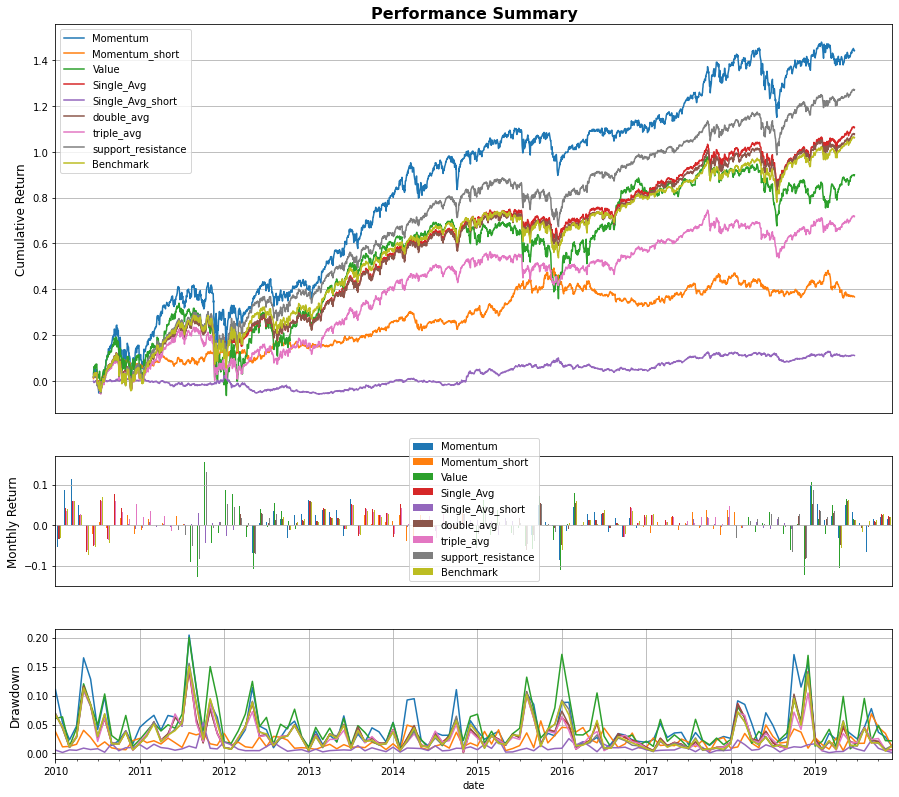

In [32]:
alphas = [
    Momentum(),
    Momentum_short(),
    Value_Momentum(),
    Rolling_Single_Avg(),
    Rolling_Single_Avg_short(),
    Rolling_Double_Avg(),
    Rolling_Triple_Avg(),
    Support_Resistance(),
    Alpha()
]

returns, holdings = backtester.backtest(alphas, processes=None)

metrics.summary_plot(returns, source=['Momentum', 'Momentum_short', 'Value', 'Single_Avg', 'Single_Avg_short', 'double_avg', 'triple_avg', 'support_resistance', 'Benchmark' ])

In [26]:
alphas = [Momentum(),
          Momentum_short(),
          Support_Resistance(),
          Rolling_Single_Avg()
]

from IPython.core import display as ICD
perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

Momentum


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.326624,1.137100,1.551666,0.227006,0.106441,51.0,0.0
2011,-0.035728,-0.124087,-0.164575,0.258052,0.106303,51.0,0.0
2012,0.158376,1.018198,1.467657,0.113743,0.115325,51.0,0.0
2013,0.392586,2.474511,3.537065,0.082837,0.102944,51.0,0.0
2014,0.149867,0.787193,1.035823,0.146711,0.091416,51.0,0.0
2015,0.076986,0.476587,0.672151,0.114914,0.102458,51.0,0.0
2016,0.011771,0.087452,0.108066,0.144573,0.112627,51.0,0.0
2017,0.163330,1.250892,1.567864,0.054171,0.113305,51.0,0.0
2018,-0.027417,-0.116644,-0.153514,0.269739,0.091255,51.0,0.0



Momentum_short


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.086952,1.079055,1.639012,0.053508,0.123178,51.0,50.0
2011,0.044249,0.515578,0.802106,0.055092,0.121387,51.0,50.0
2012,0.023379,0.325122,0.483849,0.047301,0.125671,51.0,50.0
2013,0.105613,1.878956,2.920096,0.024931,0.119567,51.0,50.0
2014,0.032681,0.442520,0.629353,0.080699,0.124077,51.0,50.0
2015,0.160765,1.640460,2.324042,0.057142,0.099449,51.0,50.0
2016,-0.098694,-1.000646,-1.498480,0.141244,0.119407,51.0,50.0
2017,0.022800,0.328594,0.402484,0.050395,0.125381,51.0,50.0
2018,0.018120,0.220043,0.315292,0.097341,0.104978,51.0,50.0



support_resistance


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.246681,1.043704,1.478712,0.178624,0.007458,51.0,0.0
2011,-0.167704,-0.497856,-0.655675,0.354895,0.008992,51.0,0.0
2012,0.233926,1.245953,2.005685,0.177527,0.007273,51.0,0.0
2013,0.319361,2.297320,3.381083,0.068096,0.006147,51.0,0.0
2014,0.028883,0.234615,0.309069,0.102474,0.005494,51.0,0.0
2015,-0.087864,-0.471161,-0.697765,0.167147,0.005763,51.0,0.0
2016,0.247635,1.123472,1.468500,0.198468,0.006610,51.0,0.0
2017,0.095286,0.890330,1.336811,0.081569,0.008390,51.0,0.0
2018,-0.188005,-1.178628,-1.492453,0.268200,0.007186,51.0,0.0



Single_Avg


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.188965,0.973205,1.290568,0.154311,0.098919,355.178571,0.0
2011,-0.000362,-0.001754,-0.002215,0.190295,0.153510,304.734127,0.0
2012,0.093546,0.748299,1.107058,0.104064,0.088590,335.352000,0.0
2013,0.303265,2.532827,3.580209,0.064480,0.040877,401.301587,0.0
2014,0.117786,0.997469,1.307716,0.080574,0.082560,361.547619,0.0
2015,-0.006122,-0.041695,-0.057771,0.105579,0.125147,256.575397,0.0
2016,0.077362,0.634921,0.824908,0.067664,0.104422,273.579365,0.0
2017,0.186161,2.534757,3.450210,0.030043,0.048060,330.569721,0.0
2018,-0.079923,-0.504802,-0.591326,0.189190,0.113358,264.067729,0.0


4it [01:55, 28.97s/it]


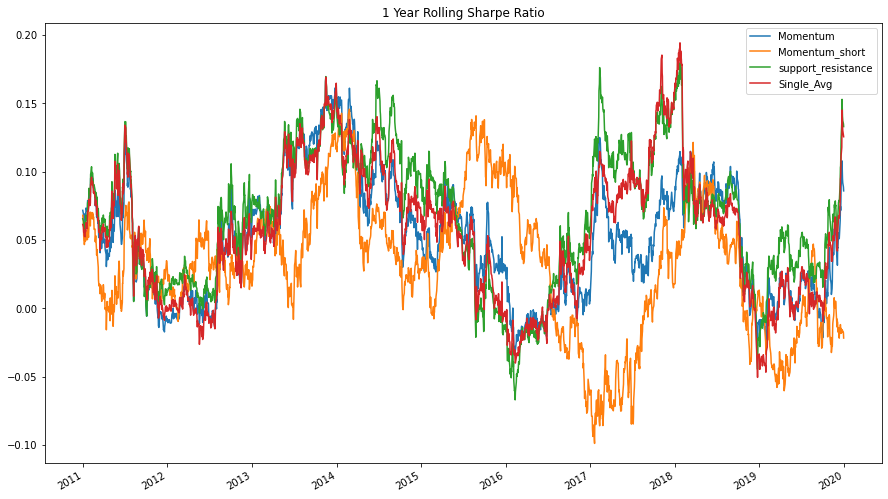

In [29]:
import functools
alphas = [Momentum(), Momentum_short(), Support_Resistance(), Rolling_Single_Avg()]
returns, holdings = backtester.backtest(alphas, processes=None)
rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
returns.apply(rolling_sharpe).plot()
plt.title('1 Year Rolling Sharpe Ratio')
plt.show()

### Further questions to consider

1. Change the date range to see how strategies perform during different periods.  
2. Develop a systematic way of testing different parameters that can improve performance.
3. Implement long/short versions for each strategies. How do they perform?
4. The momentum strategies use uniform weights for each stock. Does weighting by standard deviation i.e. $w_i \propto 1 / \sigma_i$ improve results?
5. Use different metrics to measure momentum such as cumulative returns or risk adjusted returns.
6. Use exponential averages for the moving averages strategies.